# Binning

This example shows how LiberTEM can be used for fast binning of a large dataset.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sparse
import matplotlib.pyplot as plt

from libertem.api import Context
from libertem.udf.masks import ApplyMasksUDF

In [3]:
ctx = Context()

/home/weber/miniconda3/envs/libertem39/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33311 instead
  warnings.warn(
2023-01-12 17:46:05,328 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-20335/worker-puok182k', purging
2023-01-12 17:46:05,329 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-20335/worker-aabyao71', purging
2023-01-12 17:46:05,329 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-20335/worker-2ka8wcft', purging
2023-01-12 17:46:05,329 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-20335/worker-jywv_h_e', purging
2023-01-12 17:46:05,329 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-20335/worker-pexwfimn', purging
2023-01-12 17:

2023-01-12 17:46:05,590 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=8)
2023-01-12 17:46:05,591 - distributed.utils - INFO - Reload module tmptm7nqrea from .py file
2023-01-12 17:46:05,624 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=18)
2023-01-12 17:46:05,625 - distributed.utils - INFO - Reload module tmphal63ifm from .py file
2023-01-12 17:46:05,635 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=16)
2023-01-12 17:46:05,635 - distributed.utils - INFO - Reload module tmp51es4m7y from .py file
2023-01-12 17:46:05,638 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=5)
2023-01-12 17:46:05,638 - distributed.utils - INFO - Reload mod

2023-01-12 17:46:05,951 - distributed.preloading - INFO - Import preload module: /tmp/tmpm6jjgc2g.py
2023-01-12 17:46:05,951 - distributed.preloading - INFO - Creating preload: from libertem.common.tracing import maybe_setup_tracing; maybe_setup_tracing(service_name='default-cpu-5', service_id='5')
2023-01-12 17:46:05,951 - distributed.utils - INFO - Reload module tmpwrkxfs_9 from .py file
2023-01-12 17:46:05,952 - distributed.preloading - INFO - Import preload module: /tmp/tmpwrkxfs_9.py
2023-01-12 17:46:05,952 - distributed.preloading - INFO - Creating preload: libertem.preload
2023-01-12 17:46:05,952 - distributed.preloading - INFO - Import preload module: /tmp/tmphal63ifm.py
2023-01-12 17:46:05,952 - distributed.preloading - INFO - Creating preload: from libertem.common.tracing import maybe_setup_tracing; maybe_setup_tracing(service_name='default-cpu-18', service_id='18')
2023-01-12 17:46:05,952 - distributed.utils - INFO - Reload module tmpev6kwut7 from .py file
2023-01-12 17:46:0

## Generate test data
Just a folded linear gradient for illustration

In [4]:
shape = (17, 19, 23, 29)
data = np.linspace(0, 1, np.prod(shape, dtype=np.int64)).reshape(shape)

In [5]:
ds = ctx.load('memory', data=data)

## Define the binning factor and determine target shape

In [6]:
bin_factor = 4

In [7]:
# ceil() to include output bins that only fit partially into the
# source frame
size_y = int(np.ceil(ds.shape.sig[0] / bin_factor))
size_x = int(np.ceil(ds.shape.sig[1] / bin_factor))

## Create a sparse matrix for binning
Each layer corresponds to an output bin. We calculate which pixels are in each output bin.

In [8]:
bin_matrix_layers = []
for y in range(size_y):
    for x in range(size_x):
        layer = np.zeros(ds.shape.sig)
        start_y = y * bin_factor
        stop_y = (y + 1) * bin_factor
        start_x = x * bin_factor
        stop_x = (x + 1) * bin_factor
        layer[start_y:stop_y, start_x:stop_x] = 1
        layer /= np.sum(layer)
        bin_matrix_layers.append(sparse.COO(layer))
bin_matrix = sparse.stack(bin_matrix_layers)

In [9]:
def mask_factory():
    return bin_matrix

## Apply the matrix

In [10]:
udf = ApplyMasksUDF(mask_factories=mask_factory)
result = ctx.run_udf(dataset=ds, udf=udf, progress=True)

Partitions 0/24, Frames:   0%|          | 0/323 [00:00<?, ?it/s]

/home/weber/miniconda3/envs/libertem39/lib/python3.9/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.65 MiB detected in task graph: 
  (<UDFTask [<class 'libertem.udf.masks.ApplyMasksUD ... -cf73ad3e178c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


## Reshape and show result

In [11]:
reshaped_result = result['intensity'].raw_data.reshape(*ds.shape.nav, size_y, size_x)

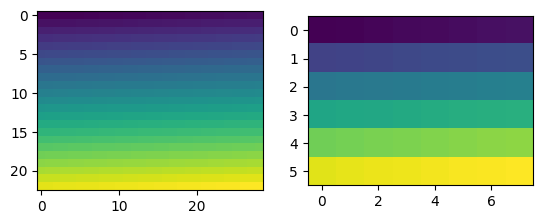

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data[0, 0])
axes[1].imshow(reshaped_result[0, 0])